<a href="https://colab.research.google.com/github/NahidS1311/CSE445_Project_Group2/blob/main/support/cellNucleiSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import os
from glob import glob
import cv2
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

Pre-Processing

In [ ]:
!unzip -q /content/stage1_train.zip -d /content/working/

In [ ]:
def load_sample(image_id,target_size=(256,256)):

    # Paths
    base_path = '/content/working'
    img_path=os.path.join(base_path,image_id,'images',image_id+'.png')
    mask_folder=os.path.join(base_path,image_id,'masks')

    # Load Images
    img=cv2.imread(img_path)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img=cv2.resize(img,target_size)

    # Create empty mask
    mask=np.zeros(target_size,dtype=np.uint8)

    # Combining all individual masks
    for mask_file in glob(os.path.join(mask_folder,'*.png')):
        msk=cv2.imread(mask_file,cv2.IMREAD_GRAYSCALE)
        msk=cv2.resize(msk,target_size)
        mask=np.maximum(mask,msk)

    # Expand mask dims to (H, W, 1)
    mask = np.expand_dims(mask , axis=-1)
    mask = (mask > 0).astype(np.float32)  # Binarize: convert to 0s and 1s

    return img , mask


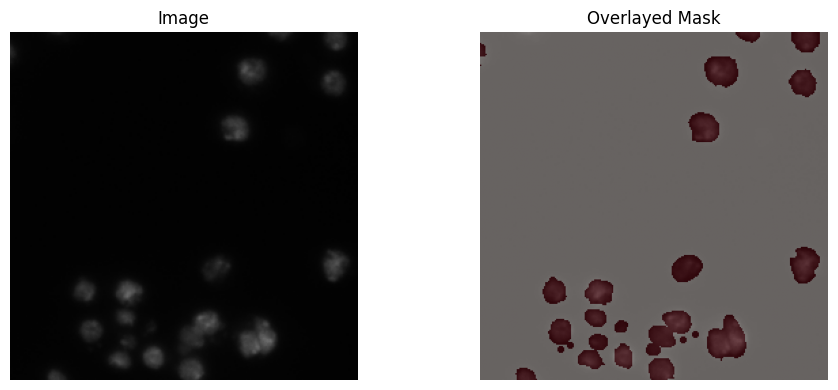

In [ ]:
image_dirs = sorted(glob('/content/working/*'))
sample_id = os.path.basename(image_dirs[0])

img, msk = load_sample(sample_id)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img)
plt.imshow(msk.squeeze(), cmap='Reds', alpha=0.4)
plt.title("Overlayed Mask")
plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
def list_sample_ids(data_dir):
    return [
        d for d in os.listdir(data_dir)
        if os.path.isdir(os.path.join(data_dir, d)) and not d.startswith(".")
    ]


def data_loader(data_dir,target_size=(256,256)):
    img_ids = list_sample_ids(data_dir)
    X,Y=[] , []

    for id in img_ids:
        try:
            img, mask = load_sample(id , target_size=target_size)
            X.append(img)
            Y.append(mask)
        except Exception as e:
            print(e)
            break

    X=np.array(X,dtype=np.float32)
    Y=np.array(Y,dtype=np.float32)

    return X , Y

X,Y = data_loader('/content/working')
print("Loaded images:", X.shape)
print("Loaded masks:", Y.shape)


Loaded images: (670, 256, 256, 3)
Loaded masks: (670, 256, 256, 1)


In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

train_ds=tf.data.Dataset.from_tensor_slices((X_train,Y_train)).batch(16).shuffle(100).prefetch(tf.data.AUTOTUNE)
val_ds=tf.data.Dataset.from_tensor_slices((X_train,Y_train)).batch(16).prefetch(tf.data.AUTOTUNE)

Model Building

In [ ]:
def conv_block(input_tensor,num_filters):
    x= tf.keras.layers.Conv2D(num_filters,(3,3),padding='same',activation='relu')(input_tensor)
    x=tf.keras.layers.Conv2D(num_filters,(3,3),padding='same',activation='relu')(x)
    return x

def decoder_block(input_tensor,skip_tensor,num_filters):
    x= tf.keras.layers.Conv2DTranspose(num_filters,(2,2),strides=(2,2),padding='same')(input_tensor)
    x= tf.keras.layers.Concatenate()([x,skip_tensor]) # skip connection

    x= conv_block(x,num_filters)

    return x


In [ ]:
def build_unet(input_shape):
    inputs=tf.keras.Input(shape=input_shape)

    # Encoder
    c1= conv_block(inputs,64)
    p1=tf.keras.layers.MaxPooling2D((2,2))(c1)

    c2=conv_block(p1,128)
    p2=tf.keras.layers.MaxPooling2D((2,2))(c2)

    c3=conv_block(p2,256)
    p3=tf.keras.layers.MaxPooling2D((2,2))(c3)

    c4=conv_block(p3,512)
    p4=tf.keras.layers.MaxPooling2D((2,2))(c4)


    # Bottleneck

    bn=conv_block(p4,1024)

    # Decoder
    d1=decoder_block(bn,c4,512)
    d2=decoder_block(d1,c3,256)
    d3=decoder_block(d2,c2,128)
    d4=decoder_block(d3,c1,64)

    outputs=tf.keras.layers.Conv2D(1,(1,1),activation='sigmoid')(d4)

    return tf.keras.models.Model(inputs=inputs, outputs=outputs)


In [ ]:
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)  # Binarize predictions
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    return (2. * intersection + smooth) / (union + smooth)

model=build_unet((256,256,3))
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy',dice_coef])


In [ ]:
earlystop_cb = tf.keras.callbacks.EarlyStopping(
    patience=4,
    restore_best_weights=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

reduce_lr_cb = tf.keras.callbacks.ReduceLROnPlateau(
    factor=0.5,
    patience=3,
    monitor='val_loss',
    mode='min',
    verbose=1
)


In [ ]:
history = model.fit(train_ds, epochs=30, validation_data=val_ds , callbacks=[ earlystop_cb, reduce_lr_cb])


Epoch 1/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 188s 3s/step - accuracy: 0.6807 - dice_coef: 0.1462 - loss: 1.5485 - val_accuracy: 0.8753 - val_dice_coef: 0.2720 - val_loss: 0.5648 - learning_rate: 0.0010
Epoch 2/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.8738 - dice_coef: 0.3121 - loss: 0.5569 - val_accuracy: 0.9018 - val_dice_coef: 0.5494 - val_loss: 0.4872 - learning_rate: 0.0010
Epoch 3/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 34s 1000ms/step - accuracy: 0.8956 - dice_coef: 0.5224 - loss: 0.4924 - val_accuracy: 0.9176 - val_dice_coef: 0.6446 - val_loss: 0.3442 - learning_rate: 0.0010
Epoch 4/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.8858 - dice_coef: 0.4729 - loss: 0.3430 - val_accuracy: 0.9075 - val_dice_coef: 0.5648 - val_loss: 0.1871 - learning_rate: 0.0010
Epoch 5/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 34s 999ms/step - accuracy: 0.9153 - dice_coef: 0.6111 - loss: 0.2382 - val_accuracy: 0.9234 - val_dice_coef: 0.6822 - val_loss: 0.1725 - learning_rate: 0.0010
Epoch 6/30
34/34 ━━━━━

Evaluation

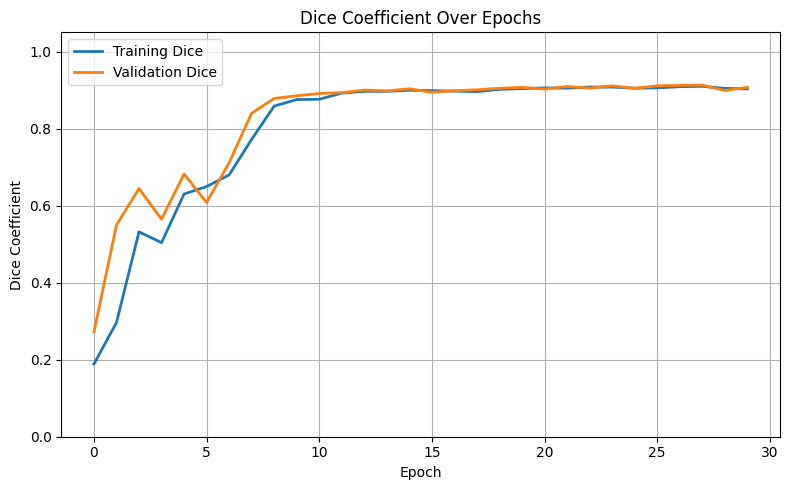

In [ ]:
dice = history.history['dice_coef']
val_dice = history.history['val_dice_coef']

# Plot
plt.figure(figsize=(8, 5))
plt.plot(dice, label='Training Dice', linewidth=2)
plt.plot(val_dice, label='Validation Dice', linewidth=2)
plt.title('Dice Coefficient Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.ylim(0, 1.05)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


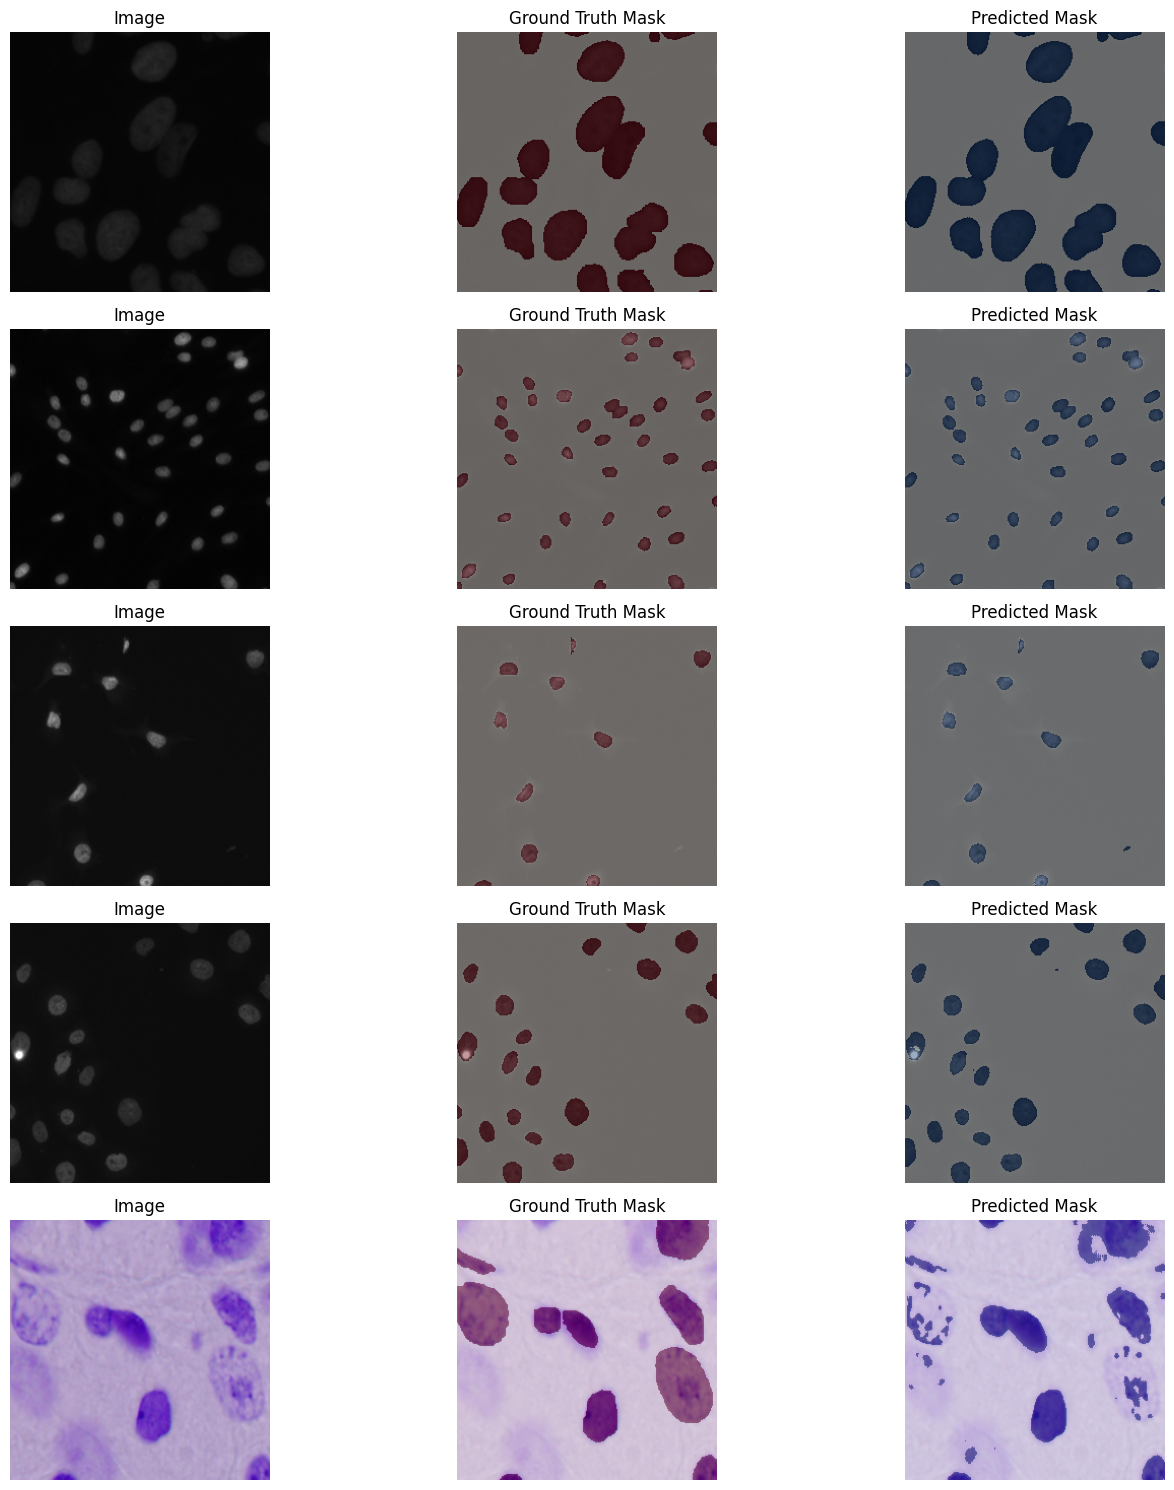

In [ ]:
# Grab one batch from the validation set
val_imgs, val_masks = next(iter(val_ds))

# Predict on it
preds = model.predict(val_imgs)
preds = (preds > 0.5).astype(np.uint8)  # Binarize predictions

# Plot some results
import matplotlib.pyplot as plt

n = 5  # number of samples to display
plt.figure(figsize=(15, n * 3))

for i in range(n):
    plt.subplot(n, 3, i*3 + 1)
    plt.imshow(val_imgs[i].numpy().astype("uint8"))
    plt.title("Image")
    plt.axis('off')

    plt.subplot(n, 3, i*3 + 2)
    plt.imshow(val_imgs[i].numpy().astype("uint8"))
    plt.imshow(val_masks[i].numpy().squeeze(), alpha=0.4, cmap='Reds')
    plt.title("Ground Truth Mask")
    plt.axis('off')

    plt.subplot(n, 3, i*3 + 3)
    plt.imshow(val_imgs[i].numpy().astype("uint8"))
    plt.imshow(preds[i].squeeze(), alpha=0.4, cmap='Blues')
    plt.title("Predicted Mask")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# Save the entire model
model.save('/content/unet_model.keras')
